In [16]:
import numpy as np
import scipy as sp
from math import pi, tanh
from cmath import sqrt
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact

In [150]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=10*hwc #1e2*meV
mu_sc=10.1*hwc #1e2*meV
D_sc=0.5*hwc #10*meV
nu=0.01#sqrt(2)+0.1
mu_n=nu*hwc #10*meV

lambd=.0*vF
gs=0.*hwc
gn=0.1*hwc


Ls=20*lB
Lx=12*lB
Nx=200
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

def E_bands(ky_sw):
    Hx= hbar*vF*np.kron(np.diag(kx) , sigma2)
    HeB= -2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma1)
    HeBT= -2j*vF*elec*B* np.kron(np.imag(y1(k2-k1)), sigma1)

    Hxm= np.kron( y0s(k1-k2) , m_sc*sigma3)
    HxmT= np.kron( y0s(k2-k1) , m_sc*sigma3)
    Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )
    HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1), sigma0 )

    Hd= np.kron(D_sc*y0s(k1-k2),sigma0)
    # basis ud,ud
    dmat=np.array([[0.,1.],[0.,0.]])
    ddmat=np.kron(dmat,np.array([[0.,1.],[-1.,0.]]))
    Hd_mat=np.kron(ddmat,Hd)
    Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

#     Hlx=hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron(k1*y0s(k1-k2),sigma0) )
#     HlxT=-hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron(k1*y0s(k2-k1),sigma0) )
    Hlx=hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron( (k1+k2)/2*y0s(k1-k2),sigma0) )
    HlxT=-hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron((k1+k2)/2*y0s(k2-k1),sigma0) )
    Hz_up= -(gs*y0s(k1-k2)+2*gn*np.real(y0(k1-k2)))
    Hz= np.kron(np.array([[1,0],[0,-1]]), np.kron(Hz_up,sigma0) )
    Hz_upT= -(gs*y0s(k2-k1)+2*gn*np.real(y0(k2-k1)))
    HzT= np.kron(np.array([[1,0],[0,-1]]), np.kron(Hz_upT,sigma0) )


    En=np.zeros((8*Nx,len(ky_sw)))
    for i_y in range(len(ky_sw)):
        ky=ky_sw[i_y]
        Hy= np.kron(hbar*vF*ky*np.eye(Nx), sigma1)

        H1 = Hx +Hy + HeB + Hxm + Hef
        H1T = Hx -Hy + (HeBT + HxmT + HefT).conj()

    #     Hly=hbar*lambd*ky*np.kron(np.array([[0.,1],[1,0.]]), np.kron(y0s(k1-k2),sigma0) )
    #     HlyT=-hbar*lambd*ky*np.kron(np.array([[0.,1],[1,0.]]), np.kron(y0s(k2-k1),sigma0) )

    #     H_p=block_diag(H1,H1)+Hlx+Hly+Hz
    #     H_pT=block_diag(H1T,H1T)+(HlxT+HlyT+HzT).conj()
        H_p=block_diag(H1,H1)+Hlx+Hz
        H_pT=block_diag(H1T,H1T)+(HlxT+HzT).conj()

        H_t=block_diag(H_p,-H_pT)+Hd_mat
        En[:,i_y], __ =np.linalg.eigh(H_t)
        
    return En

ky_sw=np.linspace(-1,1,50)*7/lB
Ek = E_bands(ky_sw).T/hwc

In [142]:
Hx= hbar*vF*np.kron(np.diag(kx) , sigma2)
HeB= -2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma1)
HeBT= -2j*vF*elec*B* np.kron(np.imag(y1(k2-k1)), sigma1)

Hxm= np.kron( y0s(k1-k2) , m_sc*sigma3)
HxmT= np.kron( y0s(k2-k1) , m_sc*sigma3)
Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )
HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1), sigma0 )

Hd= np.kron(D_sc*y0s(k1-k2),sigma0)
# basis ud,ud
dmat=np.array([[0.,1.],[0.,0.]])
ddmat=np.kron(dmat,np.array([[0.,1.],[-1.,0.]]))
Hd_mat=np.kron(ddmat,Hd)
Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

Hlx=hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron( (k1+k2)/2*y0s(k1-k2),sigma0) )
HlxT=-hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron((k1+k2)/2*y0s(k2-k1),sigma0) )
Hz_up= -(gs*y0s(k1-k2)+2*gn*np.real(y0(k1-k2)))
Hz= np.kron(np.array([[1,0],[0,-1]]), np.kron(Hz_up,sigma0) )
Hz_upT= -(gs*y0s(k2-k1)+2*gn*np.real(y0(k2-k1)))
HzT= np.kron(np.array([[1,0],[0,-1]]), np.kron(Hz_upT,sigma0) )

H1 = Hx + HeB + Hxm + Hef
H1T = Hx + (HeBT + HxmT + HefT).conj()

H_p=block_diag(H1,H1)+Hlx+Hz
H_pT=block_diag(H1T,H1T)+(HlxT+HzT).conj()
H_t= block_diag(H_p,-H_pT)+Hd_mat
kmat=np.kron(np.eye(4*Nx),sigma1)
    
# Esw=np.linspace(-1,1,100)*hwc
Esw= [0.05*hwc]
Ree=np.zeros(len(Esw))
Reh=np.zeros(len(Esw))

for i_E in range(len(Esw)):
    E=Esw[i_E]/(hbar*vF)*lB
    
#     Hly=hbar*lambd*ky*np.kron(np.array([[0.,1],[1,0.]]), np.kron(y0s(k1-k2),sigma0) )
#     HlyT=-hbar*lambd*ky*np.kron(np.array([[0.,1],[1,0.]]), np.kron(y0s(k2-k1),sigma0) )

    evs, evecs = np.linalg.eig( np.dot(kmat,E*np.eye(8*Nx)- H_t/(hbar*vF)*lB ) )

#     i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
#     ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]

    ky_max = 4
    ky_min = 1e-4
    i_prop1= np.where( np.abs(np.imag(evs)) < ky_min )[0]
    i_prop2= np.where( np.abs(np.real(evs[i_prop1])) > ky_min )[0]
    i_prop3= np.where( np.abs(np.real(evs[i_prop1[i_prop2]])) < ky_max )[0]
    Jmat = np.reshape(np.diag(np.dot(np.transpose(evecs).conj(),np.dot(kmat,evecs))),[8*Nx,])
    ip_T= np.where( np.real(Jmat[i_prop1[i_prop2[i_prop3]]]) > 0)[0]
    i_p= i_prop1[i_prop2[i_prop3[ip_T]]]
#     i_p=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
    
#     print(E/hwc, evs, i_p)
    
#     evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
#     Tevecs = evecs[:,i_p]

print("Done!")

Done!


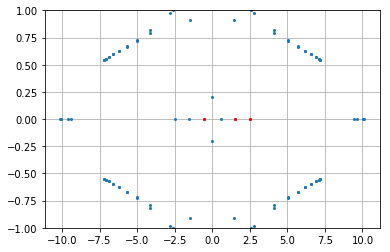

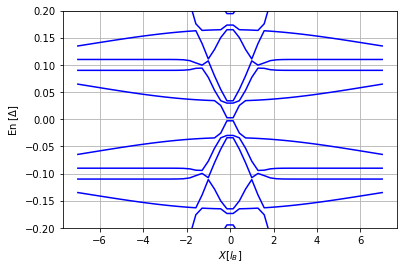

In [151]:
plt.figure()
plt.plot(np.real(evs), np.imag(evs),'o',markersize=2)
plt.plot(np.real(evs[i_p]), np.imag(evs[i_p]),'ro',markersize=2)
# plt.xlim(-2,2)
plt.ylim(-1,1)
# plt.ylim(-1e-4,1e-4)
plt.grid()

plt.figure()
plt.plot(ky_sw*lB,Ek,'b')
plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")
# plt.ylim(-22,22)
# plt.ylim(-0.015,0.015)
plt.ylim(-0.2,0.2)
plt.grid()

# print(evs[i_p])

In [44]:
# print(Ree,Reh)
# print(np.concatenate((ie_T, ip_T)))
print(i_p)

[]


In [ ]:
a= np.linalg.norm(H_t-np.matrix(H_t).H)
print(a)